# Part 2

Author: HUANG Wenjin

Student ID: 20742991

Main job: GBDT+RF+NN

## Data split

In [3]:
import pandas as pd
import numpy as np
import pickle
import gc
import os

In [4]:
def Data_output(data, index=0):
    data_output = open("stock group" + str(index) + ".pkl",'wb')
    pickle.dump(data,data_output)
    data_output.close()

def Data_input(index=0):
    data_input = open("stock group" + str(index) + ".pkl",'rb')
    data = pickle.load(data_input)
    data_input.close()
    return data

In [ ]:
Data_output(z0, index=4)

## Data reload

In [3]:
# memory checking
import psutil
from sklearn.model_selection import train_test_split
pc_mem =psutil.virtual_memory()
div_gb_factor =(1024.0 ** 3)
print("totalmemor: %fGB" % float(pc_mem.total/div_gb_factor))
print("availablememory: %fGB" % float(pc_mem.available/div_gb_factor))
print("usedmemory: %GB" % float(pc_mem.used/div_gb_factor))
print("percentof used memory: %f" % float(pc_mem.percent))
print("freememory:%fGB" % float(pc_mem.free/div_gb_factor))


totalmemor: 7.863190GB
availablememory: 5.110210GB
usedmemory: 2.75298B
percentof used memory: 35.000000
freememory:5.110210GB


In [5]:
def year_average(df):
    df["DATE"]=df["DATE"]//10000
    em=[]
    for i in df["DATE"].unique():
        take=df[df["DATE"]==i]
        em.append(take.mean().values)
    rd=pd.DataFrame(em,columns=take.columns)
    return rd

In [6]:
def train_test_loading(train_start_date, test_start_date, train_last=180000, test_last=10000):
        
    X = pd.concat([Data_input(index=0),Data_input(index=1),Data_input(index=2),
                   Data_input(index=3),Data_input(index=4)]).reindex()
    train_range = (X['DATE']>=train_start_date)&(X['DATE']<train_start_date+train_last)
    test_range = (X['DATE']>=test_start_date)&(X['DATE']<test_start_date+test_last)
    X = X.drop(columns=["RET","permno","DATE"]) 
    
    Xtrain = X[train_range]
    Xtest = X[test_range]
    del X      
    gc.collect()

    y = pd.concat([Data_input(index=0),Data_input(index=1),Data_input(index=2),
                   Data_input(index=3),Data_input(index=4)]).reindex()["RET"]
    ytrain = y[train_range]
    ytest = y[test_range]

    return Xtrain,ytrain,Xtest,ytest

In [7]:
def marco(train_start_date, test_start_date, train_last=180000, test_last=10000):
    mac = pd.read_csv("PredictorData2020.csv")
    df = pd.concat([Data_input(index=0),Data_input(index=1),Data_input(index=2),
                    Data_input(index=3),Data_input(index=4)], ignore_index=True)[["RET","DATE"]]
    train_range = (df['DATE']>=train_start_date)&(df['DATE']<train_start_date+train_last)
    test_range = (df['DATE']>=test_start_date)&(df['DATE']<test_start_date+test_last)
    df["DATE"] = df["DATE"]//100
    df = pd.merge(df, mac, how='left', left_on=['DATE'], right_on=['yyyymm'])

    y = df["RET"]
    ytrain = y[train_range]
    ytest = y[test_range]
    Xtrain = df[train_range].drop(columns=["RET","DATE","yyyymm"]) 
    Xtest = df[test_range].drop(columns=["RET","DATE","yyyymm"]) 
    return Xtrain,ytrain,Xtest,ytest

In [1]:
Xtrain,ytrain,Xtest,ytest = train_test_loading(train_start_date=19570329,test_start_date=19751231)

In [33]:
# Xtrain,ytrain,Xtest,ytest = marco(train_start_date=19570329,test_start_date=19751231)

## GBDT + H

In [22]:
from sklearn import ensemble
from sklearn.metrics import r2_score

In [23]:
gbr_params = {'n_estimators': 100, 'max_depth': 2,
          'random_state': 798, 'loss': 'huber',
          'learning_rate': 0.1} # [0.01,0.1]
gbr = ensemble.GradientBoostingRegressor(**gbr_params)

In [24]:
gbr.fit(Xtrain, ytrain)

GradientBoostingRegressor(loss='huber', max_depth=2, random_state=798)

In [25]:
 # 输出特征重要性列表
print(gbr.feature_importances_)

[0.12415923 0.02263499 0.04507239 0.14020959 0.0359207  0.08630777
 0.26322209 0.28247323]


In [26]:
r2_score(ytrain,gbr.predict(Xtrain))

0.1322494199992379

In [27]:
r2_score(ytest,gbr.predict(Xtest))

-0.009043848950333278

## RF

In [28]:
rf_params = {'n_estimators': 300, 'max_depth': 5,
          'random_state': 788, 'max_features': 3} # [3,5,10,20,30,50]
rf = ensemble.RandomForestRegressor(**rf_params)

In [29]:
rf.fit(Xtrain, ytrain)

RandomForestRegressor(max_depth=5, max_features=3, n_estimators=300,
                      random_state=788)

In [30]:
 # 输出特征重要性列表
print(rf.feature_importances_)

[0.10288811 0.04741552 0.08398244 0.14713295 0.05793168 0.08737084
 0.23750977 0.2357687 ]


In [31]:
r2_score(ytrain,rf.predict(Xtrain))

0.12708513204871985

In [32]:
r2_score(ytest,rf.predict(Xtest))

-0.028323070908788717

## NN

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

If we want to train a NN with **one layer**, input ***model_name = NN1*** and keep only one Dense layer in the below cell.

In [8]:
# parameter of NN
n_hidden_1 = 32 # NN of hidden layer 1 
n_hidden_2 = 16 # NN of hidden layer 2
n_hidden_3 = 8 # NN of hidden layer 3
n_hidden_4 = 4 # NN of hidden layer 4
n_hidden_5 = 2 # NN of hidden layer 5
n_input = 8 # features input layer, if marco then 8
l1_lambda = 1e-5 # Lambda value of l1 regulation
lr = 0.001 # learning rate
decay = 1e-7 # learning rate decreseing unit 

In [9]:
import tensorflow.keras.backend as K
def r2(y_true, y_pred):
    a = K.square(y_pred - y_true)
    b = K.sum(a)
    c = K.mean(y_true)
    d = K.square(y_true - c)
    e = K.sum(d)
    f = 1 - b/e
    return f

In [10]:
# Create model
def NN_model_create(n_layer):
    model = Sequential()

    # Layer 1
    if n_layer>=1:
        model.add(Dense(n_hidden_1, activation='relu', input_dim=n_input, 
                    kernel_initializer='random_uniform', kernel_regularizer=regularizers.l1(l1_lambda)))
        model.add(BatchNormalization())
    
    # Layer 2
    if n_layer>=2:
        model.add(Dense(n_hidden_2, activation='relu',kernel_regularizer=regularizers.l1(l1_lambda))) 
        model.add(BatchNormalization())

    # Layer 3
    if n_layer>=3:
        model.add(Dense(n_hidden_3, activation='relu',kernel_regularizer=regularizers.l1(l1_lambda))) 
        model.add(BatchNormalization())

    # Layer 4
    if n_layer>=4:
        model.add(Dense(n_hidden_4, activation='relu',kernel_regularizer=regularizers.l1(l1_lambda))) 
        model.add(BatchNormalization())

    # Layer 5
    if n_layer>=5:
        model.add(Dense(n_hidden_5, activation='relu',kernel_regularizer=regularizers.l1(l1_lambda))) 
        model.add(BatchNormalization())

    # Layer output
    model.add(Dense(1))

    # Model additional setting
    adam = optimizers.Adam(lr=lr, decay=decay)
    model.compile(loss='mse', optimizer=adam, metrics=[r2])
    model.summary()
    model_name = 'NN' + str(n_layer)
    return model, model_name

In [96]:
np.random.seed(20)
# tf.random.set_seed(2)
# os.environ['PYTHONHASHSEED'] = str(20)

# Model fitting
model, model_name = NN_model_create(n_layer=2)
early_stopping = EarlyStopping(monitor='val_r2', patience=10, mode='max')
checkpoint = ModelCheckpoint('./model/'+model_name+' best.h5', monitor='val_loss',verbose=0, 
                            save_best_only=True)

model.fit(Xtrain, ytrain, validation_data =(Xtest,ytest), shuffle=True,
          batch_size=10000, epochs=100,callbacks=[early_stopping,checkpoint])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 32)                288       
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
dense_32 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 1,025
Trainable params: 929
Non-trainable params: 96
_________________________________________________________________
Train on 773741 samples, validate on 84623 samples
Epoch 1/100
773741/773741 [==============================] - 2s 2us

Here we use the **checkpoint** to save the best model of each NN, in case of **over-fitting**.

In [49]:
# model loading ,self-defined one or the checkpoint one (if you need it)

# model = load_model('./model/'+model_name+'.h5',custom_objects={'r2': r2})
model = load_model('./model/'+model_name+' best.h5',custom_objects={'r2': r2})

In [23]:
# Model scoring
pred_test_y = model.predict(Xtest)
R2_IS = r2_score(ytrain, model.predict(Xtrain))
R2_OOS = r2_score(ytest, pred_test_y)
print('R2 in sample is',R2_IS)
print('R2 out of sample is',R2_OOS)

R2 in sample is -0.3646825505129263
R2 out of sample is -6.244869314154177


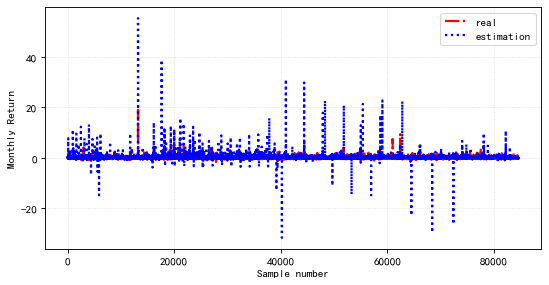

In [24]:
# Plot out fitting result
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# set the fugure shape
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(range(len(ytest)), ytest, ls='-.',lw=2,c='r',label='real')
plt.plot(range(len(pred_test_y)), pred_test_y, ls=':',lw=2,c='b',label='estimation')

# draw the grid
plt.grid(alpha=0.4, linestyle=':')
plt.legend()
plt.xlabel('Sample number') #设置x轴的标签文本
plt.ylabel('Monthly Return') #设置y轴的标签文本

# figure save and show
plt.savefig('./figure/'+ model_name +'fitting result.jpg')
plt.show()

In [74]:
# if the model is good enough, save it
model.save('./model/'+model_name+'.h5')

## Recrsive

In [11]:
def nn_importance(model, n_variable=98):
    zero_nn = model.predict(np.zeros((1,n_variable)))
    eye = np.identity(n_variable)
    feature_importance = model.predict(eye)
    feature_importance = abs(feature_importance - zero_nn)
    feature_importance = feature_importance/feature_importance.sum()
    return feature_importance

In [12]:
def importance_ranking(importance_vec, Xtrain, impor):
    
    s=pd.Series(importance_vec,index=Xtrain.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    impor.append(table)
    return impor

In [31]:
# Model recursive rolling and training，for instance NN model
im=np.zeros((98,1))
model, model_name = NN_model_create(n_layer=1) # Set nn_layer from 1 to 5
early_stopping = EarlyStopping(monitor='val_r2', patience=10, mode='max')
checkpoint = ModelCheckpoint('./model/'+model_name+' best.h5', monitor='val_loss',verbose=0, save_best_only=True)
for t in range(3):
    Xtrain,ytrain,Xtest,ytest = train_test_loading(train_start_date=19570329,test_start_date=19571231+10000*(30+t),
                                                   train_last=(18+t)*10000, test_last=10000)
#     Xtrain,ytrain,Xtest,ytest = marco(train_start_date=19570329,test_start_date=19571231+10000*(30+t),
#                                       train_last=(18+t)*10000, test_last=10000)
    ##NN1
    model.fit(Xtrain, ytrain, validation_data =(Xtest,ytest), shuffle=True,
              batch_size=10000, epochs=100,callbacks=[early_stopping,checkpoint])
    model = load_model('./model/'+model_name+' best.h5',custom_objects={'r2': r2})
    im = im + nn_importance(model,n_variable=98)
    print("recursive run :", t)
    

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                288       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_19 (Batc (None, 16)                64        
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 136       
_________________________________________________________________
batch_normalization_20 (Batc (None, 8)                 32        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                

In [32]:
from sklearn import preprocessing
# im = preprocessing.scale(rf.feature_importances_)
hp['nn5'] = (im-min(im))

I need to load the **variables importance** of the other models from csv

In [33]:
# hp.to_csv("hp3.csv")

In [13]:
# hp=pd.read_csv("hp3.csv",index_col=0)

In [34]:
hp/(hp.max(axis=0)-hp.min(axis=0))

,OLS,OLS+H,PLS,ENet,gbdt+H,rf,nn1,nn2,nn3,nn4,nn5
dp,0.411290,0.197802,1.000000,1.000000,0.390721,0.291816,0.291816,0.361253,0.450784,0.249310,0.360764
ep,1.000000,0.912088,0.958824,0.857143,0.000000,0.000000,0.000000,0.000000,0.154558,0.335837,0.377334
bm,0.274194,0.000000,0.735294,0.714286,0.086351,0.192362,0.192362,0.699946,0.249814,0.083646,0.865867
ntis,0.258065,0.505495,0.282353,0.571429,0.452492,0.524568,0.524568,1.000000,0.181941,0.160272,0.223841
tbl,0.032258,0.076923,0.464706,0.428571,0.051131,0.055321,0.055321,0.880065,0.000000,0.000000,0.278798
tms,0.895161,1.000000,0.394118,0.285714,0.245048,0.210187,0.210187,0.577314,0.730449,0.769256,0.000000
dfy,0.096774,0.351648,0.258824,0.142857,0.925911,1.000000,1.000000,0.512131,1.000000,1.000000,0.075382
svar,0.000000,0.208791,0.000000,0.000000,1.000000,0.990841,0.990841,0.760975,0.663929,0.042235,1.000000


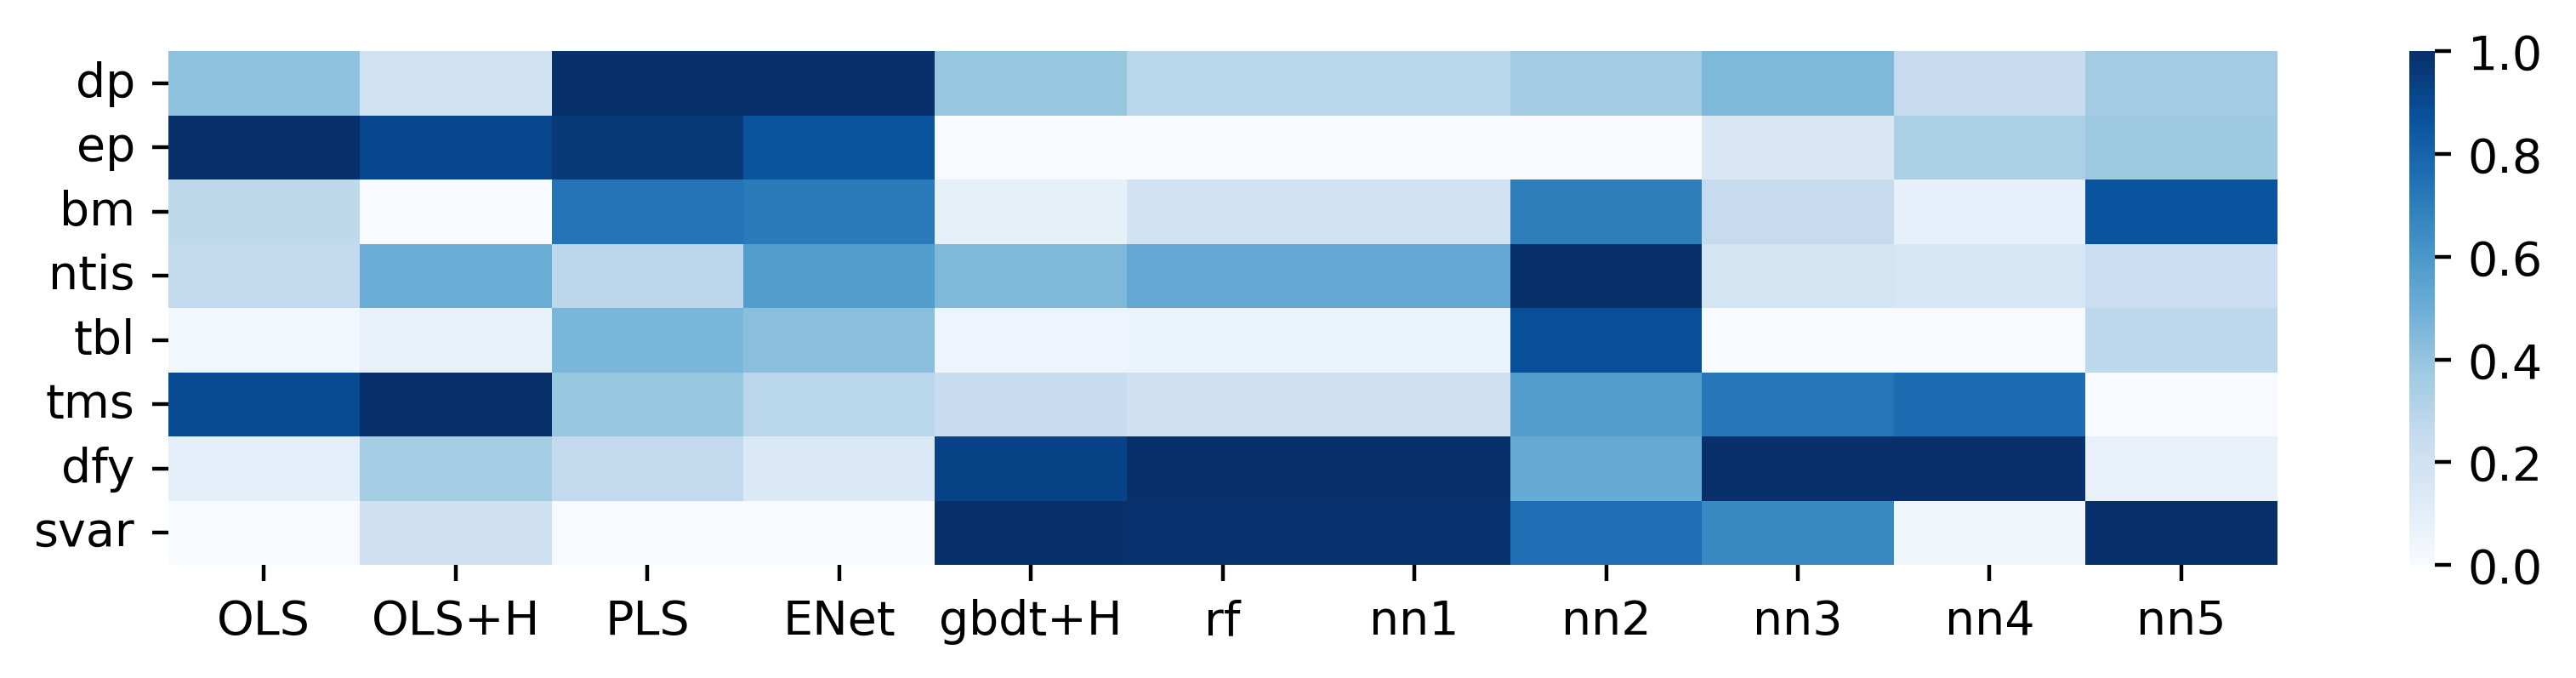

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(10,2))
sns.heatmap(hp/(hp.max(axis=0)-hp.min(axis=0)), annot=False, vmax=1, square=False, cmap="Blues",linecolor='white')
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 400 #分辨率
plt.savefig('./figure/Marco importance.jpg')
plt.show()